# Dimensionality considerations

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
colors = sns.color_palette()

sys.path.append('../src')
import raybay

In [2]:
# Load data
folder = 'ZZ_MK_LLLungSBRT3977'
approved = np.load(folder + '/approved/res_approved.pkl', allow_pickle=True)
default = np.load(folder + '/default/res_default.pkl', allow_pickle=True)
bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
bayes2 = np.load(folder + '/dimension/res_linquad_gp_minimize.pkl', allow_pickle=True)

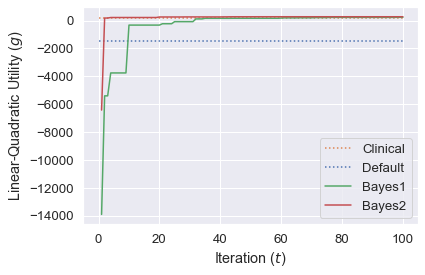

In [3]:
# Plot convergence (zoomed out)
labels = True
plt.plot([0, 100], [raybay.get_utility(bayes.goal_df, approved.goal_dict)[0], 
         raybay.get_utility(bayes.goal_df, approved.goal_dict)[0]], ':', color=colors[1])
plt.plot([0, 100], [raybay.get_utility(bayes.goal_df, default.goal_dict)[0], 
         raybay.get_utility(bayes.goal_df, default.goal_dict)[0]], ':', color=colors[0])
plt.plot(np.arange(1, 101), -np.minimum.accumulate(bayes.opt_result.func_vals), color=colors[2])
plt.plot(np.arange(1, 101), -np.minimum.accumulate(bayes2.opt_result.func_vals), color=colors[3])
if labels:
    plt.xlabel('Iteration ($t$)')
    plt.ylabel('Linear-Quadratic Utility ($g$)')
    plt.legend(['Clinical', 'Default', 'Bayes1', 'Bayes2'])
else:
    ylim = plt.ylim()
    plt.xticks(np.arange(0, 101, 20), labels=[])
    plt.yticks(plt.yticks()[0], labels=[])
    plt.ylim(ylim)
plt.savefig('fig10a.png', bbox_inches='tight', dpi=300)

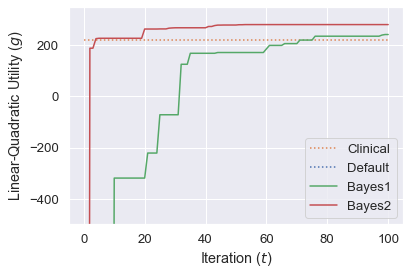

In [4]:
# Plot convergence (zoomed in)
labels = True
plt.plot([0, 100], [raybay.get_utility(bayes.goal_df, approved.goal_dict)[0], 
         raybay.get_utility(bayes.goal_df, approved.goal_dict)[0]], ':', color=colors[1])
plt.plot([0, 100], [raybay.get_utility(bayes.goal_df, default.goal_dict)[0], 
         raybay.get_utility(bayes.goal_df, default.goal_dict)[0]], ':', color=colors[0])
plt.plot(np.arange(1, 101), -np.minimum.accumulate(bayes.opt_result.func_vals), color=colors[2])
plt.plot(np.arange(1, 101), -np.minimum.accumulate(bayes2.opt_result.func_vals), color=colors[3])
plt.ylim(-500, 350)
if labels:
    plt.xlabel('Iteration ($t$)')
    plt.ylabel('Linear-Quadratic Utility ($g$)')
    plt.legend(['Clinical', 'Default', 'Bayes1', 'Bayes2'])
else:
    plt.xticks(np.arange(0, 101, 20), labels=[])
    plt.yticks(plt.yticks()[0], labels=[])
    plt.legend(['']*4, frameon=False)
    plt.ylim(-500, 350)
plt.savefig('fig10b.png', bbox_inches='tight', dpi=300)

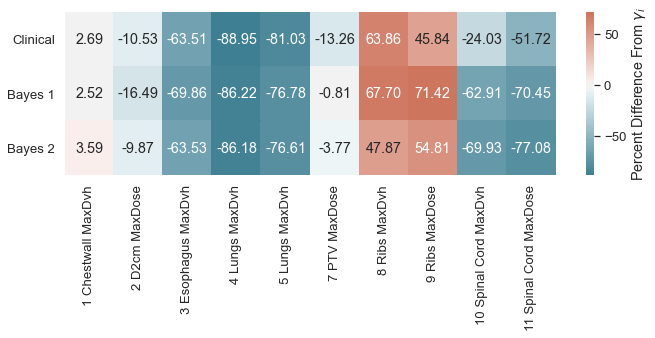

In [5]:
# Plot goal values (relative to gamma)
roi_names = ['Chestwall', 'D2cm', 'Esophagus', 'Lungs', 'Lungs', 'PTV', 'PTV', 'Ribs', 'Ribs',
             'Spinal Cord', 'Spinal Cord']

# Get index of optimal utility
idx_max = [0]
idx_max.append(np.argmin(bayes.opt_result.func_vals))
idx_max.append(np.argmin(bayes2.opt_result.func_vals))

# Calculate goal values
val_list = []
roi_dict = {}
res_list = [approved, bayes, bayes2]
for index, row in bayes.goal_df.iterrows():
    goal_vals = []
    if index != 5:
        roi_dict[f"{index + 1} {roi_names[index]} {row['Type']}"] = index + 1
        for ii in range(len(res_list)):
            level = res_list[1].goal_df.iloc[index]['AcceptanceLevel']
            val = res_list[ii].goal_dict[index][idx_max[ii]]
            goal_vals.append(100*(val - level)/level)
        val_list.append(goal_vals)

# Plot results
columns=['Clinical', 'Bayes 1', 'Bayes 2']
val_df = pd.DataFrame(columns=columns, data=val_list, index=roi_dict)
fig, ax = plt.subplots(1, figsize=(len(bayes.goal_df), len(columns)))
sns.heatmap(val_df.transpose(), cmap=sns.diverging_palette(220, 20, n=256), center=0,
            annot=True, fmt=".2f", cbar_kws={'label': 'Percent Difference From $\gamma_i$'}, ax=ax)
plt.yticks(rotation='horizontal')
plt.savefig('fig11.png', dpi=300, bbox_inches='tight')